# Paramagnetic Relaxation Enhancement: Dipolar Relaxation

In this example, we'll investigate the relaxation induced by presence of an anisotropic (dipolar) hyperfine coupling. We'll start with a 4-site tetrahedral exchange to mimic tumbling (this is an isotropic motion, with a single correlation time, as is isotropic tumbling)

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
import SLEEPY as RS
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Relaxation due to isotropic motion of dipolar hyperfine coupling
In this case, we expect the following relaxation behavior for longitudinal and transverse relaxation
\begin{eqnarray}
\Gamma_{I_z,I_z}^{(IS)}&=&\frac{S(S+1)}{12}(\delta^{(IS)})^2\left[3J_2^Z(\omega_I)+7J_2^X(\omega_S)\right]\\
\Gamma_{I^+,I^+}^{(IS)}&=&\frac{S(S+1)}{24}(\delta^{(IS)})^2\left[4J_2^Z(0)+3J_2^Z(\omega_I)+13J_2^X(\omega_S)\right]\\
\Gamma_{I_z,S_z}^{(IS)}&=&\frac{S(S+1)}{12}(\delta^{(IS)})^25J_2(\omega_S)
\end{eqnarray}

In [3]:
delta=2e4

ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(RS.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],LF=True,pwdavg=RS.PowderAvg()[50]))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,phi_tetra,k*2*np.pi/3])

<IPython.core.display.Javascript object>


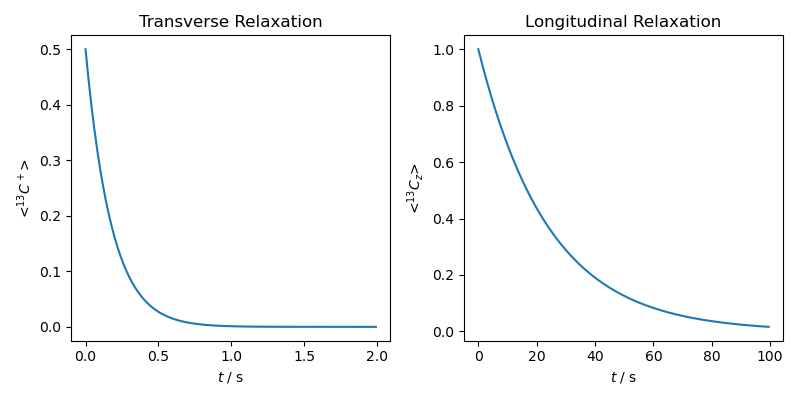

In [4]:
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(5e-8)
U=L.U(Dt=.01)

fig,ax=plt.subplots(1,2)
fig.set_size_inches([8,4])

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')
ax[0].set_title('Transverse Relaxation')

U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz')
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')
ax[1].set_title('Longitudinal Relaxation')
fig.tight_layout()

In the above simulation, we see that the isotropic motion from a dipolar hyperfine coupling induces both transverse and longitudinal relaxation. Next, we'll check the correlation time dependence of both relaxation processes.

<IPython.core.display.Javascript object>


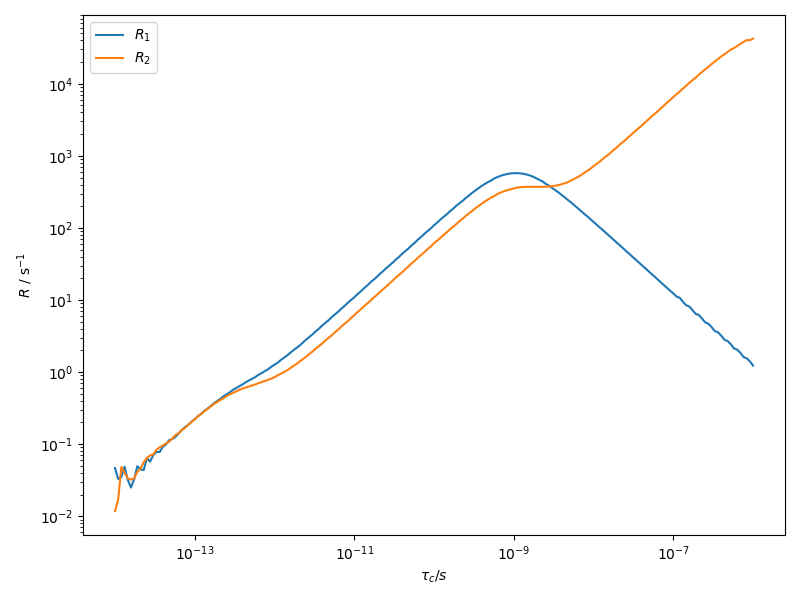

In [5]:
delta=5e5
ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(RS.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],LF=True,pwdavg=RS.PowderAvg()[50]))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,phi_tetra,k*2*np.pi/3])

L=RS.Liouvillian(ex)
    
rhoT=RS.Rho(rho0='13Cx',detect='13Cp')
rhoL=RS.Rho(rho0='13Cz',detect='13Cz')
tc0=np.logspace(-14,-6,201)

R1=list()
R2=list()

DtT=.1
DtL=.05

for tc in tc0:
    L.kex=RS.Tools.fourSite_sym(tc)
    U=L.U(Dt=DtT)
    rhoT.clear()
    rhoT.DetProp(U,n=100)
    i0=np.abs(rhoT.I[0])<0.45
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        DtT=rhoT.t_axis[i]/5
    else:
        i=99
        DtT*=10
    
    R2.append((0.5-np.abs(rhoT.I[0,i]))/rhoT.t_axis[i]*2)
    
    U=L.U(Dt=DtL)
    rhoL.clear()
    rhoL.DetProp(U,n=100)
    i0=np.abs(rhoL.I[0])<0.9
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        DtL=rhoT.t_axis[i]/5
    else:
        i=99
        DtL*=10
    
    R1.append((1-np.abs(rhoL.I[0,i]))/rhoL.t_axis[i])

fig,ax=plt.subplots(1,1)
fig.set_size_inches([8,6])
ax.loglog(tc0,R1)
ax.loglog(tc0,np.array(R2))
ax.set_xlabel(r'$\tau_c / s$')
ax.set_ylabel(r'$R$ / s$^{-1}$')
ax.legend((r'$R_1$',r'$R_2$'))
fig.tight_layout()

Above, we see a maximum in the hyperfine-induced $T_1$ at the nuclear Larmor frequency, as expected. The simulation becomes unstable at shorter corrlation times (work needed), but we do indeed also see a second maximum at the electron Larmor frequency. The $T_2$ grows continues to grow as we go to shorter correlation times. Note that with a correlation time near the electron Larmor frequency, we should also see Overhause effect, which we verify below.

<IPython.core.display.Javascript object>


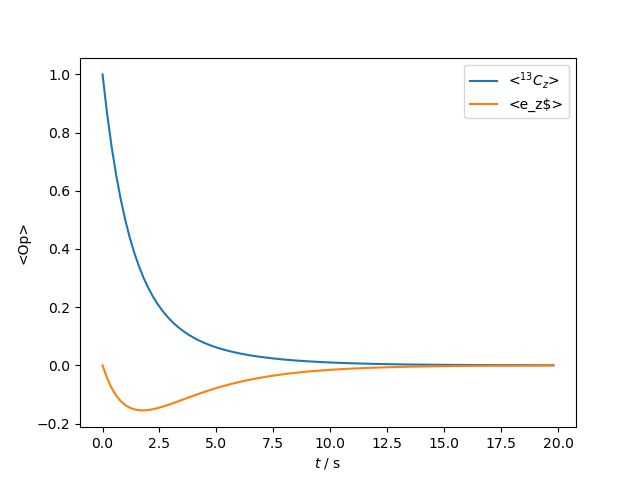

<AxesSubplot:xlabel='$t$ / s', ylabel='<Op>'>

In [6]:
L.kex=RS.Tools.fourSite_sym(4e-13)
U=L.U(Dt=.2)
rho=RS.Rho(rho0='13Cz',detect=['13Cz','ez'])
rho.DetProp(U,n=100)
rho.plot(axis='s')

As expected, we find some transfer to the electron when the correlation time is near the inverse of the electron Larmor frequence ($\tau_c\approx1/\omega_{0e}$)

## Relaxation due to electron $T_1$ and $T_2$
We can rely on the same formulas as above:
\begin{eqnarray}
\Gamma_{I_z,I_z}^{(IS)}&=&\frac{S(S+1)}{12}(\delta^{(IS)})^2\left[3J_2^Z(\omega_I)+7J_2^X(\omega_S)\right]\\
\Gamma_{I^+,I^+}^{(IS)}&=&\frac{S(S+1)}{24}(\delta^{(IS)})^2\left[4J_2^Z(0)+3J_2^Z(\omega_I)+13J_2^X(\omega_S)\right]\\
\Gamma_{I_z,S_z}^{(IS)}&=&\frac{S(S+1)}{12}(\delta^{(IS)})^25J_2(\omega_S)
\end{eqnarray}
We should pay special attention to the superscript on the spectral densities. $T_2$ relaxation will contribute to $J_2^X(\omega)$ but not $J_2^Z(\omega)$, whereas $T_1$ relaxation will contribute to $J_2^Z(\omega)$ but not $J_2^X(\omega)$.

Then, as a first step, we will just introduce $T_2$ relaxation. Note that then we only sample the spectral density at the electron Larmor frequency


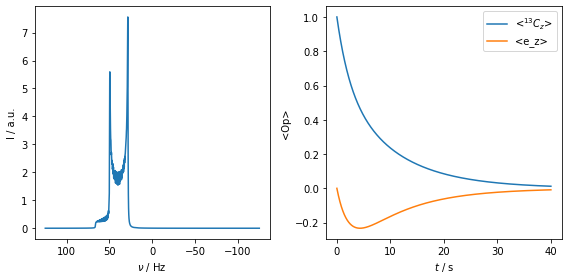

In [9]:
ex=RS.ExpSys(v0H=600,vr=100000,Nucs=['13C','e-'],LF=True,pwdavg=RS.PowderAvg(q=6))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-200000,Ayy=-200000,Azz=400000)

L=RS.Liouvillian(ex)
L.clear_relax()
L.add_relax(Type='T2',i=1,T2=4e-13)
U=L.U()**400

fig,ax=plt.subplots(1,2)
fig.set_size_inches(8,4)

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=1000)
rho.downmix()
rho.plot(ax=ax[0],FT=True,apodize=True)
# rho.plot(ax=ax[0])

rho=RS.Rho(rho0='13Cz',detect=['13Cz','e-z'])
rho.DetProp(U,n=10000)
rho.plot(ax=ax[1],axis='s')
fig.tight_layout()

Unfortunately, the hyperfine couplings tilt the nucleus too much to be spun out entirely. This will make extraction of the transverse rate constants tricky, but just for understanding, we'll look at $T_1$ rate constant as a function of correlation time.

In [10]:
rhoL=RS.Rho(rho0='13Cz',detect='13Cz')
T20=np.logspace(-14,-9,41)

R1=list()

N=100

for T2 in T20:
    L.clear_relax()
    L.add_relax(Type='T2',i=1,T2=T2)
    
    U=L.U()**N
    rhoL.clear()
    rhoL.DetProp(U,n=100)
    i0=np.abs(rhoL.I[0])<0.9
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        N=int(rhoL.t_axis[i]/L.taur)
    else:
        i=99
        N*=10
    
    R1.append((1-np.abs(rhoL.I[0,i]))/rhoL.t_axis[i])

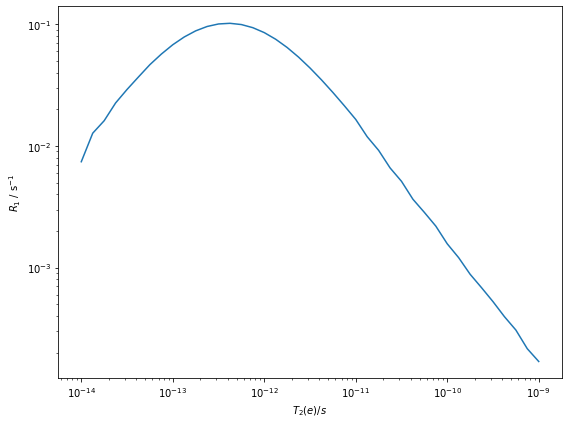

In [11]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches([8,6])
ax.loglog(T20,R1)
ax.set_xlabel(r'$T_2(e) / s$')
ax.set_ylabel(r'$R_1$ / s$^{-1}$')
fig.tight_layout()

As expected, we just find the one maximum at the electron Larmor frequency.

In the next example, we'll fix the electron $T_2$ and add an electron $T_1$

<IPython.core.display.Javascript object>


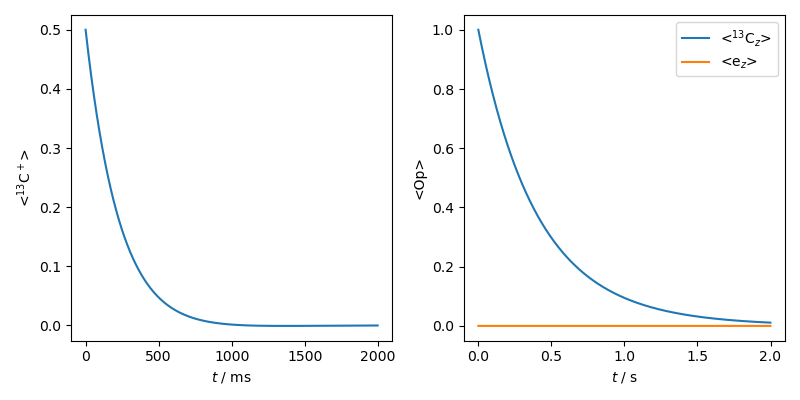

In [91]:
delta=4e4
ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],LF=True)
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

L=RS.Liouvillian(ex)
L.add_relax(Type='T2',i=1,T2=4e-13)
L.add_relax(Type='T1',i=1,T1=1e-9)

U=L.U()**10

fig,ax=plt.subplots(1,2)
fig.set_size_inches(8,4)


rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=2000)
rho.downmix()
rho.plot(ax=ax[0])

rho=RS.Rho(rho0='13Cz',detect=['13Cz','ez'])
rho.DetProp(U,n=2000)
rho.plot(ax=ax[1],axis='s')
fig.tight_layout()

Contributions at the nuclear Larmor frequency are much larger than those at the electron Larmor frequency (we even reduced the size of the coupling for these plots). Note that there is no Overhauser effect at this frequency. Next we sweep over $T_1$.

In [ ]:
rhoL=RS.Rho(rho0='13Cz',detect='13Cz')
rhoT=RS.Rho(rho0='13Cx',detect='13Cp')
T10=np.logspace(-12,-6,41)

R1=list()
R2=list()

N=5000
NT=5000

for T1 in T10:
    L.clear_relax()
    L.add_relax(Type='T2',i=1,T2=4e-13)
    L.add_relax(Type='T1',i=1,T1=T1)
    
    U=L.U()**min(N,NT)
    UL=U**max(1,int(N/NT))
    rhoL.clear()
    rhoL.DetProp(UL,n=100)
    i0=np.abs(rhoL.I[0])<0.9
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        N=max(1,int(rhoL.t_axis[i]/L.taur/10))
    else:
        i=99
        N*=10
        
    R1.append((1-np.abs(rhoL.I[0,i]))/rhoL.t_axis[i])
    
    
    UT=U**max(1,int(NT/N))
    rhoT.clear()
    rhoT.DetProp(U,n=100)
    i0=np.abs(2*rhoT.I[0])<0.9
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        NT=max(1,int(rhoT.t_axis[i]/L.taur/10))
    else:
        i=99
        NT*=10
        
    R2.append((1-2*np.abs(rhoT.I[0,i]))/rhoT.t_axis[i])
    

<IPython.core.display.Javascript object>


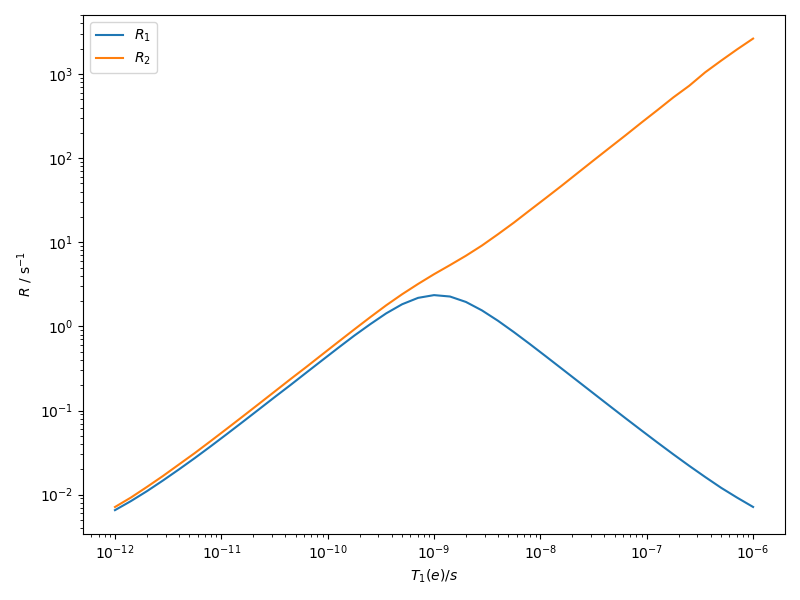

In [106]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches([8,6])
ax.loglog(T10,R1)
ax.loglog(T10,R2)
ax.set_xlabel(r'$T_1(e) / s$')
ax.set_ylabel(r'$R$ / s$^{-1}$')
ax.legend((r'$R_1$',r'$R_2$'))
fig.tight_layout()

Then, we obtain a maximum at the nuclear Larmor frequency from sweeping the electron $T_1$

## Combined influence of isotropic motion and electron $T_1$ and $T_2$
In the next section, we investigate how the combination of isotropic motion and electron $T_1$ and $T_2$ interact. In each example, we start with relaxation from one source, and then add the second source to compare the results

In [3]:
#Set up spin system
delta=2e4

ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(RS.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],LF=True,pwdavg=RS.PowderAvg()[50]))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,phi_tetra,k*2*np.pi/3])

<IPython.core.display.Javascript object>


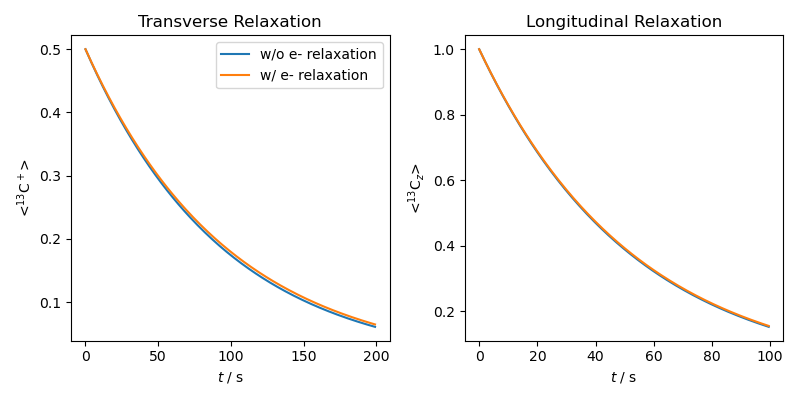

In [131]:
#Start just with fast exchange
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(1e-11)

fig,ax=plt.subplots(1,2)
fig.set_size_inches([8,4])

U=L.U(Dt=1)
#First simulate just with exchange
rho=RS.Rho(rho0='13Cx',detect='13Cp')  #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')



U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz')  #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


#Now add electron relaxation
L.add_relax(Type='T2',i=1,T2=1e-9)
L.add_relax(Type='T1',i=1,T1=1e-9)
U=L.U(Dt=1)

rho=RS.Rho(rho0='13Cx',detect='13Cp') #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')


U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz') #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


ax[0].set_title('Transverse Relaxation')
ax[1].set_title('Longitudinal Relaxation')
ax[0].legend(('w/o e- relaxation','w/ e- relaxation'))
fig.tight_layout()

The result is that the relaxation curves do not change: the isotropic motion fully removes the hyperfine couplings so that electron relaxation does not add any additional contributions. We can also reverse the roles, making the $T_1$ and $T_2$ fast, and isotropic motion slow.

<IPython.core.display.Javascript object>


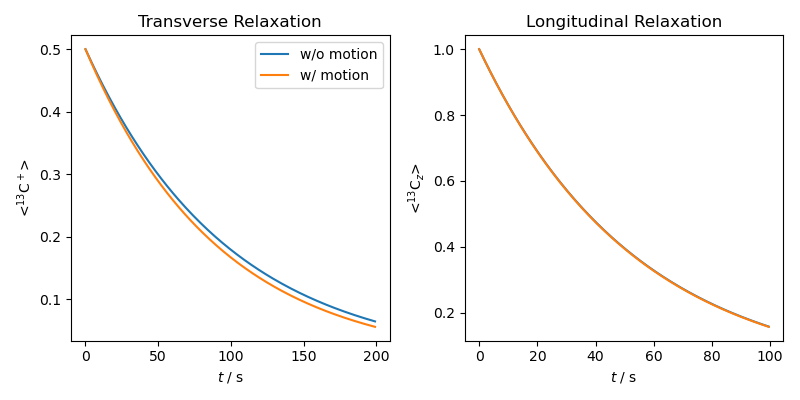

In [132]:
#Start just with electron relaxation (technically, we also have very slow exchange)
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(1e-3)  #We still include some slow relaxation to average together the components
L.add_relax(Type='T2',i=1,T2=1e-11)
L.add_relax(Type='T1',i=1,T1=1e-11)

fig,ax=plt.subplots(1,2)
fig.set_size_inches([8,4])

U=L.U(Dt=1)
#First simulate just with exchange
rho=RS.Rho(rho0='13Cx',detect='13Cp')  #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')



U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz')  #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


#Now make the exchange faster (near nuclear T1)
L.kex=RS.Tools.fourSite_sym(1e-9)  
U=L.U(Dt=1)

rho=RS.Rho(rho0='13Cx',detect='13Cp') #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')


U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz') #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


ax[0].set_title('Transverse Relaxation')
ax[1].set_title('Longitudinal Relaxation')
ax[0].legend(('w/o motion','w/ motion'))
fig.tight_layout()

Again, the result is that the relaxation curves do not change: the electron relaxation fully removes the hyperfine couplings so that isotropic motion does not add any additional contributions.

In the last example, we investigate what happens if the correlation times are the same (or similar).

<IPython.core.display.Javascript object>


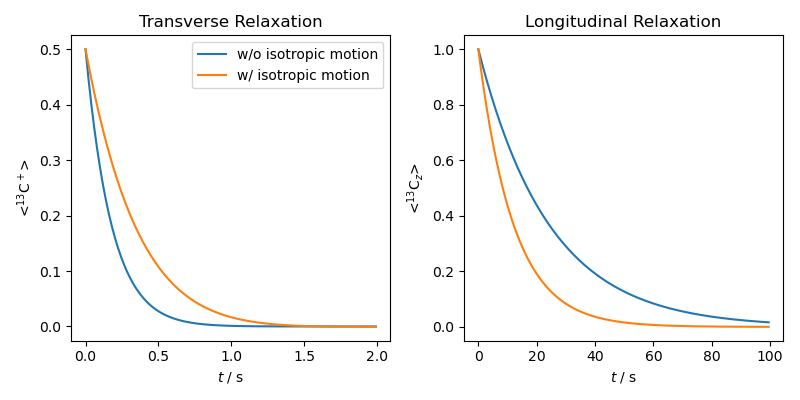

In [136]:
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(1e-3)  #We still include some slow relaxation to average together the components
L.add_relax(Type='T2',i=1,T2=5e-8)
L.add_relax(Type='T1',i=1,T1=5e-8)

fig,ax=plt.subplots(1,2)
fig.set_size_inches([8,4])

U=L.U(Dt=.01)
#First simulate just with exchange
rho=RS.Rho(rho0='13Cx',detect='13Cp')  #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')


U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz')  #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


#Now make the exchange fast
L.kex=RS.Tools.fourSite_sym(5e-8) 
U=L.U(Dt=.01)

rho=RS.Rho(rho0='13Cx',detect='13Cp') #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')


U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz') #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


ax[0].set_title('Transverse Relaxation')
ax[1].set_title('Longitudinal Relaxation')
ax[0].legend(('w/o isotropic motion','w/ isotropic motion'))
fig.tight_layout()

In this case, both electron relaxation and the isotropic motion contribute to the overall relaxation, as seen above. This is because neither motion is fast enough to remove the influence of the other. The combined effect can be thought of as the result of effective correlation times. These are given as:

\begin{eqnarray}
\tau_{c1}^{-1}&=&\tau_c^{-1}+T_{1S}T{-1}\\
\tau_{c2}^{-1}&=&\tau_c^{-1}+T_{2S}T{-1}
\end{eqnarray}

where $\tau_{c1}$ can be used to calculate $J_2^Z(\omega)$ and $\tau_{c2}$ can be used to calculate $J_2^X(\omega)$, as follows:

\begin{eqnarray}
J_2^Z(\omega)&=&\frac25\frac{\tau_{c1}}{1+(\tau_{c1}\omega)^2})\\
J_2^X(\omega)&=&\frac25\frac{\tau_{c2}}{1+(\tau_{c2}\omega)^2})
\end{eqnarray}

In the last example, we can show that two motions have the same effective correlation time, but from different sources has the same relaxation behavior (in the former case, relaxation comes from both isotropic motion and electron $T_1$ and $T_2$, and in the latter case, all relaxation comes from the isotropic motion, but which is set to be faster to have the same effective correlation time).

<IPython.core.display.Javascript object>


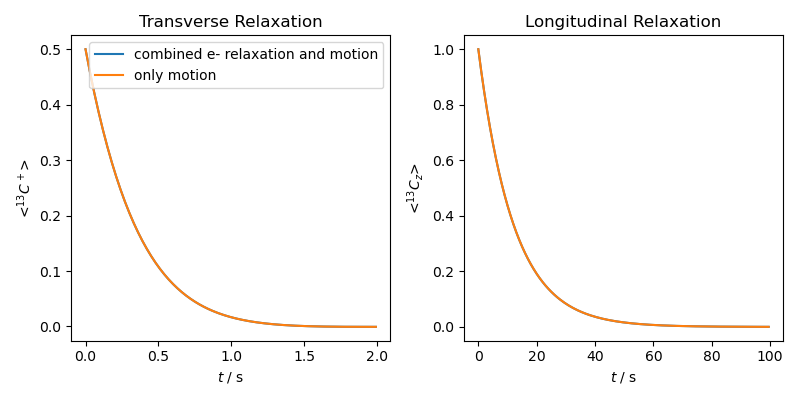

In [4]:
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(5e-8)  #We still include some slow relaxation to average together the components
L.add_relax(Type='T2',i=1,T2=5e-8)
L.add_relax(Type='T1',i=1,T1=5e-8)

fig,ax=plt.subplots(1,2)
fig.set_size_inches([8,4])

U=L.U(Dt=.01)
#First simulate just with exchange
rho=RS.Rho(rho0='13Cx',detect='13Cp')  #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')



U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz')  #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


#Now make the exchange fast
L.clear_relax()
L.kex=RS.Tools.fourSite_sym(2.5e-8)  #We still include some slow relaxation to average together the components
U=L.U(Dt=.01)

rho=RS.Rho(rho0='13Cx',detect='13Cp') #Transverse
rho.DetProp(U,n=200)
rho.downmix()
rho.plot(ax=ax[0],axis='s')


U=L.U(Dt=.5)
rho=RS.Rho(rho0='13Cz',detect='13Cz') #Longitudinal
rho.DetProp(U,n=200)
rho.plot(ax=ax[1],axis='s')


ax[0].set_title('Transverse Relaxation')
ax[1].set_title('Longitudinal Relaxation')
ax[0].legend(('combined e- relaxation and motion','only motion'))
fig.tight_layout()